In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, func

In [11]:
import numpy as np
import pandas as pd

In [12]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [14]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [32]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [36]:
engine.execute('SELECT * FROM measurement').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (16, 'USC00519397', '2010-01-18', 0.0, 72.0),
 (17, 'USC00519397', '2010-01-19', 0.0, 66.0),
 (18, 'USC00519397', '2010-01-20', 0.0, 66.0),
 (19, 'USC00519397', '2010-01-21', 0.0, 69.0),
 (20, 'USC00519397', '2010-01-22', 0.0, 67.0),
 (21, 'USC00519397', '2010-01-23', 0.0, 67.0),
 (22, 'USC00519397

# Exploratory Climate Analysis

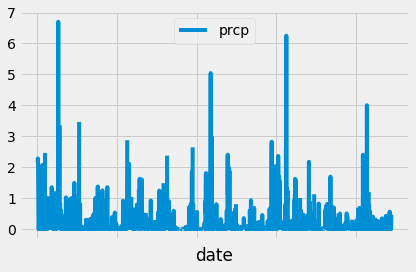

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
engine.execute('SELECT date, prcp FROM Measurement ORDER BY date DESC').fetchall()

date = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date).all()
results

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results)
df.set_index('date', inplace=True)
df.head(10)

# Sort the dataframe by date
sort_df = df.sort_values('date', ascending=True)
sort_df.head(10)

# Use Pandas Plotting with Matplotlib to plot the data
sort_df.plot()
plt.tight_layout()
plt.legend(loc='upper center')
plt.show()


![precipitation](Images/precipitation.png)

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sort_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [21]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
print(stations)

9


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = active_stations[0][0]

temperatures = session.query(func.min(Measurement.tobs),
                            func.max(Measurement.tobs),
                            func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
temperatures

[(54.0, 85.0, 71.66378066378067)]

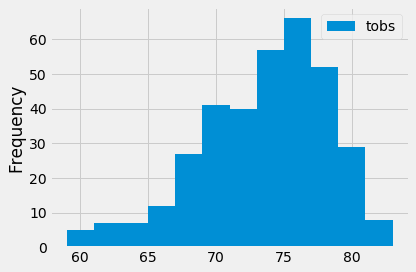

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# s as a histogram
temp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= date, Measurement.station == most_active).all()
temp_results

temp_df = pd.DataFrame(temp_results)
temp_df.set_index('date', inplace=True)
temp_df.head(10)

ax = temp_df.plot.hist(bins=12)
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temp1=calc_temps('2016-08-23', '2017-08-23')
print(calc_temp1)

[(58.0, 74.59058295964125, 87.0)]


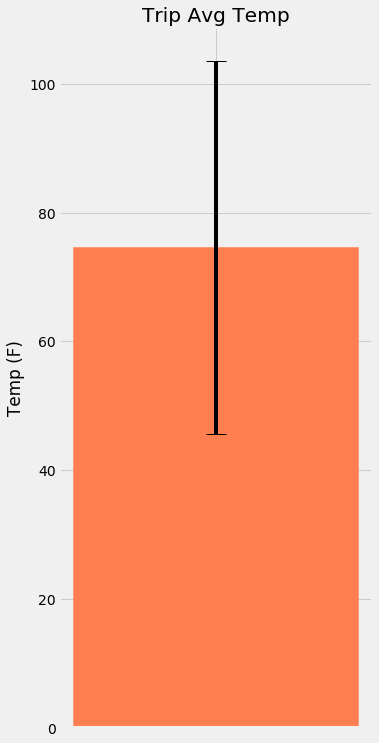

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_df = pd.DataFrame(calc_temp1, columns=['min', 'avg', 'max'])
temp_df.head()
temp_min = list(temp_df['min'])
temp_avg = list(temp_df['avg'])
temp_max = list(temp_df['max'])
t_peak = list(temp_df['max'] - temp_df['min'])

# Build the plot
plt.figure(figsize=(5,12))
barlist=plt.bar([''],temp_avg,yerr=t_peak, capsize=10)
#plt.axis([0,0,0,100])
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')

#plt.tight_layout()
barlist[0].set_color('coral')
plt.savefig('MinAvgMaxBar.png')
plt.show()

In [40]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-08-23'
end_date = '2017-08-23'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 147.81000000000006), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 70.03000000000003), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 48.510000000000026), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 38.01), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 33.239999999999995), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 16.089999999999986), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


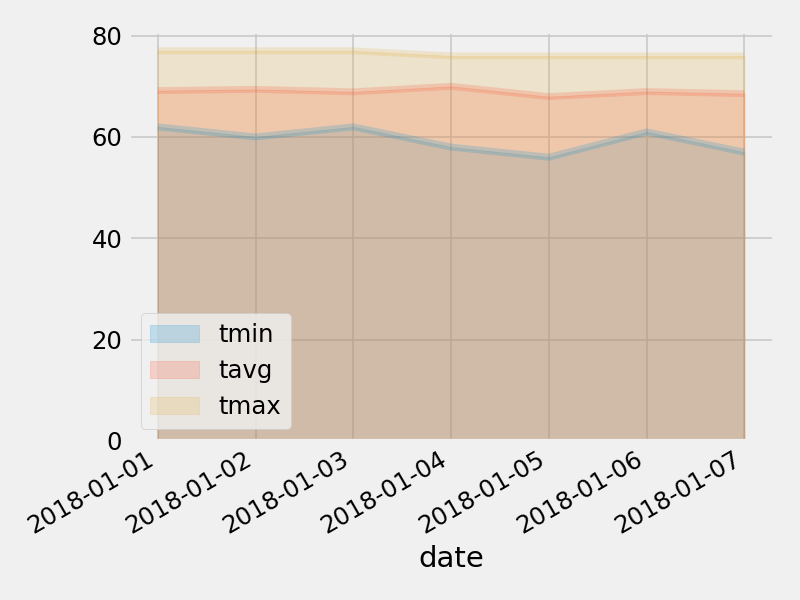

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
